In [2]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image


In [3]:
dataset_path = "RGB_224x224"


In [4]:
train_dir = os.path.join(dataset_path, "train")

In [6]:
classes = os.listdir(train_dir)

In [8]:
len(classes)

139

In [9]:
random.sample(classes, 5)

['Soursop plant',
 'Cherimoya plant',
 'Lemons and limes plant',
 'Millet plant',
 'Tea plant']

In [10]:
def show_sample_images(num_classes = 4):
    fig, axes = plt.subplots(num_classes, 5, figsize = (15, 3 * num_classes))
    for i, class_name in enumerate(random.sample(classes, num_classes)):
        class_path = os.path.join(train_dir, class_name)
        images = os.listdir(class_path)

        for j in range(5):
            img_path = os.path.join(class_path, images[j])
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].set_title(class_name)
            axes[i, j].axis("off")
    plt.tight_layout()
            




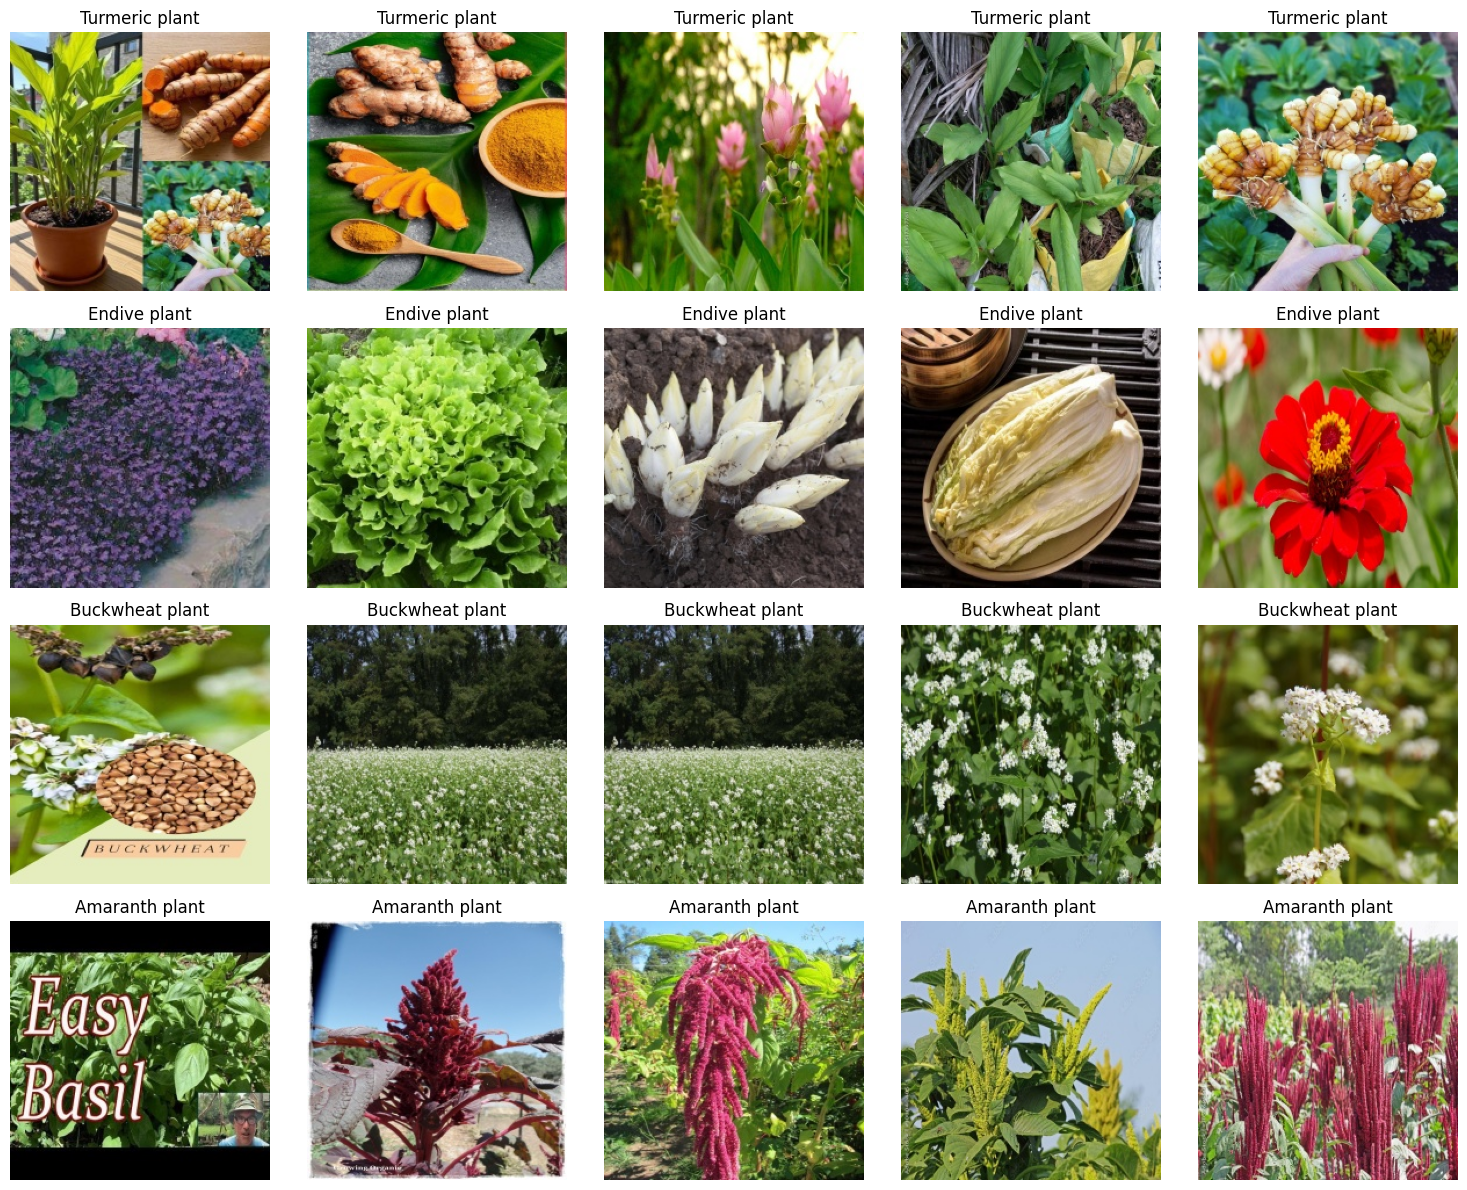

In [11]:
show_sample_images()

In [25]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [26]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.255])
])

In [28]:
train_dataset = ImageFolder(os.path.join(dataset_path, "train"), transform = transform)
val_dataset = ImageFolder(os.path.join(dataset_path, "val"), transform = transform)
test_dataset = ImageFolder(os.path.join(dataset_path, "test"), transform = transform)

In [31]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers= 4)
val_loader = DataLoader(val_dataset, batch_size=34, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = 34, shuffle=False)

In [32]:
import torchvision.models as models
import torch.nn as nn

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
device

device(type='cpu')

In [36]:
model = models.resnet18(pretrained = True)


c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\pc/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:39<00:00, 1.18MB/s]


In [37]:
for param in model.parameters():
    param.requires_grad = False
    

In [38]:
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [39]:
import torch.optim as optim
import torch.nn.functional as f

In [40]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [41]:
def train_one_epoch(model, loader):
    model.train()
    running_loss= 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss = loss.item()

    return running_loss / len(loader)    

In [42]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch,no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _. predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct/total        

In [ ]:
epochs = 5

for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader)
    val_acc = evaluate(model, val_loader)
    print(f"epoch {epoch + 1}, Train loss: {train_loss:.4f}, Val Accuracy: {val_acc:.4f}")



c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def visualize_predictions(model, loader, n=5):
    model.eval()
    images.shown = 0
    class_names = train_dataset.classes

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _. preds = torch.max(outputs, 1)

            for i in range(n):
                img = images[i].cpu.permute(1,2,0).numpy()
                plt.imshow((img* 0.229 + 0.485))
                plt.title(f"True: {class_names[labels[i]]}, pred: {class_names[preds[i]]}")
                plt.axis("off")
                plt.show()

                images_shown += 1

                if images_shown >=n:
                    return
            

In [ ]:
visualize_predictions(model, test_loader, 3)

In [ ]:
import joblib


In [ ]:
model_data = (
    "model_state_dic" : model.state_dict(),
    "class_to_idx": train_dataset.class_to_idx
)

In [ ]:
model_data

In [ ]:
joblib.dump(model_data, "crop_classifier_model.pkl")